## set up notebook

In [1]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc

random.seed(1976)
np.random.seed(1976)

# Data Anaylsis

## Experiment SetUp

In [3]:
from IPython.display import Image

 <img src="Figures/Figure_1.jpeg" width="800" height="800" />

In [4]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='gene']
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    for n in gff.iloc[:,-1]:
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
    return desc

desc_dict = make_desc('InData/TriTrypDB-46_TbruceiTREU927.gff')
desc_dict['Tb10.v4.0073']

'variant surface glycoprotein (VSG  pseudogene)  putative'

In [5]:
#combine read counts
exp = '{life_stage}_{fraction}_{replica}'
list_df = [exp.format(
    life_stage=life_stage,
    fraction=fraction,
    replica=replica) 
 for life_stage in ['B','P']
 for fraction in ['tot','pol','sub']
 for replica in ['1','2','3']
            ]
list_df = [n+'/res3/'+n+'/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()
#temp_df = pd.read_csv('BSF/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')

,Chr,Start,End,Strand,Length,/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam,/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam,/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam,/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam,/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam,...,/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam,/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam,/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam,/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam,/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam,/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam,/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam,/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam,/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam,/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
data_col = df.columns[5:]
data_col

Index(['/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam',
       '/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam',
       '/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam',
       '/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam',
       '/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam',
       '/tmp/2114.1.all.q/B_pol_3/B_pol_3_sorted.bam',
       '/tmp/2110.1.all.q/B_sub_1/B_sub_1_sorted.bam',
       '/tmp/2113.1.all.q/B_sub_2/B_sub_2_sorted.bam',
       '/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam',
       '/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam',
       '/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam',
       '/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam',
       '/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam',
       '/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam',
       '/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam',
       '/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam',
       '/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam',
       '/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam'],
      dty

In [7]:
#change headers
indata = df[data_col]
indata.columns = [n.split('/')[3].replace('_sorted.bam','') for  n in indata.columns]
indata.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Geneid,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,0,1,1,0,0,2,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
print(indata.shape)
indata=indata.dropna()
print(indata.shape)

(19986, 18)
(19986, 18)


## QC - MSD
visualise differences between samples

{'r': 'BSF', 'b': 'PCF'}


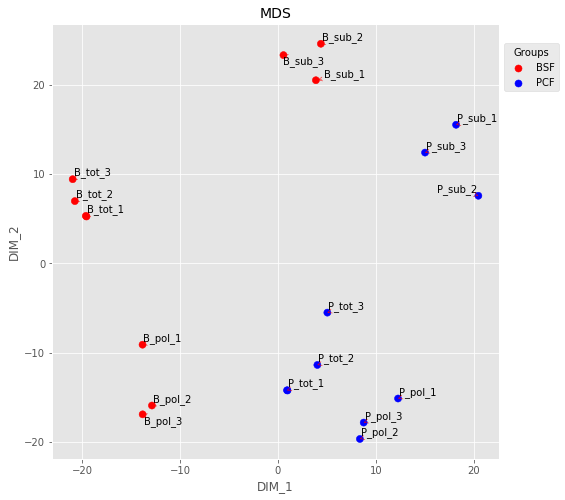

In [10]:
plt.style.use('ggplot')
palette = ['r']*9+['b']*9
fig,ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'BSF','b':'PCF'})
plt.savefig('Figures/Figure_2.png')
plt.show()

## Compute Length and GC content

In [11]:
!gtf2bed < tb927_5.gtf > tb927_5.bed
!bedtools nuc -fi tb927_5.fa -bed tb927_5.bed >InData/GC_content_927.txt

In [12]:
#function to extract the gene info
#from the "bedtools nuc -fi" outputs
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [13]:
#create a dataframe with only GC and length
#for each gene
gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
gc_content = gc_content[gc_content['8_usercol']=='transcript']
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.head()

,length,gccontent
gene_id,,
MSTRG.1,2768,0.505419
MSTRG.2,2482,0.304593
TRY.1,746,0.273458
TRY.2,1531,0.288047
TRY.3,1390,0.379856


In [14]:
#use only gene with a read count
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.head()

(19986, 18)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,0,1,1,0,0,2,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Data Normalization

### edgeR to filter low counts

In [15]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

             B_tot_1 B_tot_2 B_tot_3 B_pol_1 B_pol_2 B_pol_3 B_sub_1 B_sub_2
Tb10.v4.0073       1       1       0       0       0       0       1       0
Tb10.v4.0074       0       0       1       1       0       0       2       2
Tb10.v4.0075       0       0       0       0       0       0       0       0
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       1       0       0       0       0
Tb10.v4.0078       1       0       1       1       0       1       0       5
             B_sub_3 P_tot_1 P_tot_2 P_tot_3 P_pol_1 P_pol_2 P_pol_3 P_sub_1
Tb10.v4.0073       2       0       1       2       0       0       0       0
Tb10.v4.0074       1       0       0       0       0       0       0       0
Tb10.v4.0075       0       0       0       0       0       0       0       0
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       0       0       0       0       0

In [16]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [17]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(14389, 18)

In [18]:
indata=indata.join(gc_content,how='inner')
indata.shape

(14389, 20)

### GC / length content

In [19]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(14389, 18) (14389, 2)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.150,50,31,37,18,13,13,29,21,25,26,28,20,10,5,19,17,22,30
Tb927.8.230,3,0,3,2,4,6,12,15,21,1,0,0,0,0,1,0,0,0
Tb927.8.270,1125,955,867,663,621,591,653,680,696,721,495,391,266,249,304,578,640,719
Tb927.8.320,11,12,16,12,13,12,34,45,33,19,22,7,18,19,10,33,64,41
Tb927.8.370,8,5,2,7,2,9,19,10,10,2,0,1,0,0,1,0,0,1


### size factors

In [20]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([38356203, 35926182, 33875911, 35578481, 38350524, 40096239,
       37049693, 32663660, 33394434, 45083155, 41266775, 31183523,
       29991616, 35702840, 33686207, 28285346, 38159631, 33243997])

In [21]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction
use cqn to visualise and correct for GC and length bias

In [22]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

R[write to console]: Loading required package: mclust

R[write to console]: Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

R[write to console]: Loading required package: nor1mix

R[write to console]: Loading required package: preprocessCore

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: quantreg

R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve




In [23]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ..................
SQN .


In [24]:
%R cqn.subset

R object with classes: ('cqn',) mapped to:
[ListSexpV..., IntSexpVe..., IntSexpVe..., IntSexpVe..., ..., FloatSexp..., FloatSexp..., FloatSexp..., LangSexpV...]
R object with classes: ('cqn',) mapped to:
[ListSexpV..., IntSexpVe..., IntSexpVe..., IntSexpVe..., ..., FloatSexp..., FloatSexp..., FloatSexp..., LangSexpV...]
  lengths: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[7,764, 1,102, 13,000, 5,917, ..., 2,038, 540, 183, 2,061]
  sizeFactors: <class 'rpy2.robjects.vectors.IntArray'>
  R object with classes: ('array',) mapped to:
[38,356,203, 35,926,182, 33,875,911, 35,578,481, ..., 33,686,207, 28,285,346, 38,159,631, 33,243,997]
  subindex: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[3, 6, 7, 8, ..., 14,386, 14,387, 14,388, 14,389]
...
  x: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[-8.380822, -8.215943, -8.051065, -7.886186, ..., 7.612393, 7.777272, 7.942150, 8.107029]
  offset: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.333610, 0.438375, 0.479508, 0.507912, 0.541282]
  offset0: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[-3.014447, -0.432455, 0.485427, 1.273217, 2.867072]
  glm.offset: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x2b5a4bcb26c8> [RTYPES.LANGSXP]

### Viz Bias

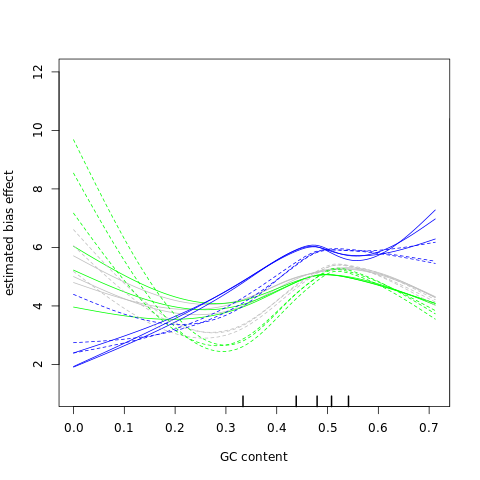

In [25]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(1,12), 
        

       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

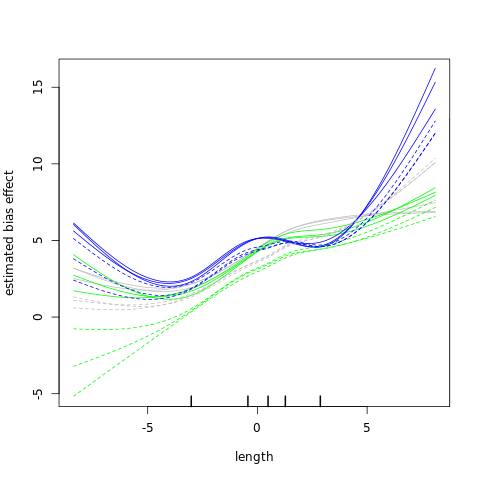

In [26]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(-5,16), 
    
       )
#dev.off()

### Bias Correction

In [27]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

              B_tot_1   B_tot_2   B_tot_3    B_pol_1     B_pol_2    B_pol_3
Tb927.8.150 -1.852563 -1.712902 -2.234817 -1.0136361 -1.29536803 -1.5843622
Tb927.8.230 -2.759846 -4.630386 -2.972667 -1.8525626 -0.95237480 -0.9523748
Tb927.8.270  3.393844  3.239970  3.087372  3.7011123  3.83427575  3.6070197
Tb927.8.320 -3.444607 -3.120658 -3.056259 -1.2953680 -0.95237480 -1.2953680
Tb927.8.370 -1.584362 -1.852563 -3.622470 -0.5173891 -2.02179848 -0.5622405
Tb927.8.443  5.158284  4.420317  4.819833  1.2049003  0.02956419  0.8751530
                B_sub_1    B_sub_2     B_sub_3     P_tot_1    P_tot_2   P_tot_3
Tb927.8.150 -0.05733432 -0.4210170 -0.45112627 -0.67313464  0.8135782 0.6433969
Tb927.8.230 -0.56224054 -0.3054536  0.06538757 -0.84180591 -0.0129485 0.2532482
Tb927.8.270  4.15411409  4.3241138  4.15122039  3.47728337  3.2506100 3.2979179
Tb927.8.320  0.54364252  0.9427932  0.08321889 -0.05733432  1.1498816 0.5203931
Tb927.8.370 -0.42101698 -0.8925478 -0.95237480 -0.67313464 -0.421017

In [28]:
#out_table

In [29]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.150,-1.852563,-1.712902,-2.234817,-1.013636,-1.295368,-1.584362,-0.057334,-0.421017,-0.451126,-0.673135,0.813578,0.643397,0.365831,-0.632863,0.942793,0.823503,0.966396,-0.121098
Tb927.8.230,-2.759846,-4.630386,-2.972667,-1.852563,-0.952375,-0.952375,-0.562241,-0.305454,0.065388,-0.841806,-0.012949,0.253248,0.587584,0.393757,1.136217,-0.305454,-0.673135,-3.084875
Tb927.8.270,3.393844,3.239970,3.087372,3.701112,3.834276,3.607020,4.154114,4.324114,4.151220,3.477283,3.250610,3.297918,3.908564,3.756117,3.802504,4.351514,4.221721,4.395912
Tb927.8.320,-3.444607,-3.120658,-3.056259,-1.295368,-0.952375,-1.295368,0.543643,0.942793,0.083219,-0.057334,1.149882,0.520393,1.824176,1.796042,1.136217,1.820284,2.330473,1.051405
Tb927.8.370,-1.584362,-1.852563,-3.622470,-0.517389,-2.021798,-0.562241,-0.421017,-0.892548,-0.952375,-0.673135,-0.421017,0.554783,0.379534,0.135419,0.908638,-0.713061,-1.013636,-2.021798


### Visualise Normalized Counts

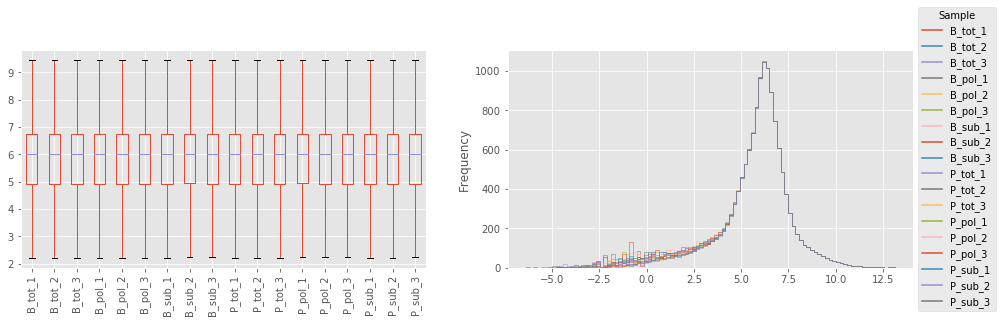

(14389, 18)


In [30]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.show()
print(out_table.shape)

## Differential Expression Analysis

In [31]:
#out_table.loc['mainVSG-427-2']

In [32]:
%%R
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  lib.size = sizeFactors,
                  group = group, 
                  )

y$offset <- cqn.subset$glm.offset
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmFit( y, design_with_all )
contrast_Bpol_v_Bsub <- glmLRT( fit_all, contrast=makeContrasts( groupBpol-groupBsub,
                                                                levels=design_with_all ) )

table_Bpol_v_Bsub <- topTags(contrast_Bpol_v_Bsub, n=Inf, 
                             sort.by = "none", adjust.method="BH")$table
topTags( contrast_Bpol_v_Bsub, n=5 )
head(table_Bpol_v_Bsub)

                 logFC     logCPM         LR       PValue          FDR
Tb927.8.150 -1.0163931 -0.5119671  6.1258709 1.332176e-02 1.739445e-02
Tb927.8.230 -1.1578114 -2.6243856  4.5403647 3.310454e-02 4.155105e-02
Tb927.8.270 -0.4951533  4.1321009 17.7178772 2.562074e-05 4.087558e-05
Tb927.8.320 -1.7984260 -0.4844273 20.7840661 5.140891e-06 8.563589e-06
Tb927.8.370 -0.2653209 -2.5063242  0.2471794 6.190682e-01 6.476966e-01
Tb927.8.443 -2.2632069  0.7747056 29.6572482 5.155948e-08 9.646201e-08


In [33]:
%%R
contrast_Ppol_v_Psub <- glmLRT( fit_all, contrast=makeContrasts(groupPpol-groupPsub,
                                                                levels=design_with_all ) )

table_Ppol_v_Psub <- topTags(contrast_Ppol_v_Psub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_Ppol_v_Psub, n=5 )

Coefficient:  1*groupPpol -1*groupPsub 
                   logFC   logCPM       LR        PValue           FDR
Tb927.10.1570   2.999099 5.876790 1500.534  0.000000e+00  0.000000e+00
KS17gene_2065a -3.598172 6.568096 1366.681 3.654503e-299 2.629232e-295
Tb927.11.6565  -3.267279 5.412596 1353.971 2.112421e-296 1.013188e-292
KS17gene_6722a -3.366655 6.593129 1262.546 1.557919e-276 5.604223e-273
KS17gene_4624a -2.903543 5.657980 1212.741 1.038298e-265 2.988015e-262


In [34]:
#desc_dict

In [35]:
%R -o table_Ppol_v_Psub
table_Ppol_v_Psub['log_PValue'] = -np.log10(table_Ppol_v_Psub['PValue'])
table_Ppol_v_Psub['log_FDR'] = -np.log10(table_Ppol_v_Psub['FDR'])
table_Ppol_v_Psub['desc']=[desc_dict.get(n,'none') for n in table_Ppol_v_Psub.index.values]
table_Ppol_v_Psub.to_csv('Tables/Table_5.csv')
table_Ppol_v_Psub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.150,-0.227976,-0.511967,0.271136,0.602571,0.643729,0.219992,0.191297,variant surface glycoprotein degenerate
Tb927.8.230,5.255793,-2.624386,3.473337,0.062365,0.080331,1.205056,1.095118,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.270,-0.504510,4.132101,16.648583,0.000045,0.000079,4.346943,4.100017,variant surface glycoprotein degenerate
Tb927.8.320,-0.236972,-0.484427,0.386027,0.534395,0.578630,0.272137,0.237599,variant surface glycoprotein degenerate
Tb927.8.370,1.989544,-2.506324,0.961448,0.326822,0.372222,0.485688,0.429198,expression site-associated gene 3 (ESAG3) deg...


In [36]:
%R -o table_Bpol_v_Bsub
table_Bpol_v_Bsub.head()
table_Bpol_v_Bsub['log_PValue'] = -np.log10(table_Bpol_v_Bsub['PValue'])
table_Bpol_v_Bsub['log_FDR'] = -np.log10(table_Bpol_v_Bsub['FDR'])

In [37]:
table_Bpol_v_Bsub['desc']=[desc_dict.get(n,'none') for n in table_Bpol_v_Bsub.index.values]
table_Bpol_v_Bsub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.150,-1.016393,-0.511967,6.125871,0.013322,0.017394,1.875438,1.759589,variant surface glycoprotein degenerate
Tb927.8.230,-1.157811,-2.624386,4.540365,0.033105,0.041551,1.480112,1.381418,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.270,-0.495153,4.132101,17.717877,0.000026,0.000041,4.591408,4.388536,variant surface glycoprotein degenerate
Tb927.8.320,-1.798426,-0.484427,20.784066,0.000005,0.000009,5.288962,5.067344,variant surface glycoprotein degenerate
Tb927.8.370,-0.265321,-2.506324,0.247179,0.619068,0.647697,0.208262,0.188628,expression site-associated gene 3 (ESAG3) deg...


In [38]:
table_Bpol_v_Bsub.to_csv('Tables/Table_4.csv')

### Grumpy

In [39]:
ks_lncRNA = open('InData/GS_gene_list.txt').read().split('\n')
def grampy_VolcanoPlot(table,title,ax=False,ksgene='KS17gene_3137a',xlims=False):
    plt.style.use('ggplot')
    if not ax:
        fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    
    table.plot(x='logFC',y='log_FDR',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    
    temp = [n for n in ks_lncRNA if n in table.index.values]
    table.loc[temp].plot(x='logFC',y='log_FDR',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                              label='lncRNA')
    
    
    table.loc[[ksgene]].plot(y='log_FDR',x='logFC',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    
    lgnd= ax.legend()
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    if xlims:
        ax.set_xlim(xlims[0],xlims[1])

def grampy_MAplot(table,title,ksgene='KS17gene_3137a'):
    plt.style.use('ggplot')
    fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    table.plot(x='logCPM',y='logFC',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    temp = [n for n in ks_lncRNA if n in table.index.values]
    table.loc[temp].plot(x='logCPM',y='logFC',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                             label='lncRNA')
    table.loc[[ksgene]].plot(y='logFC',x='logCPM',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    lgnd= ax.legend()
    for i,n in enumerate(lgnd.legendHandles):
        n._sizes = [20]

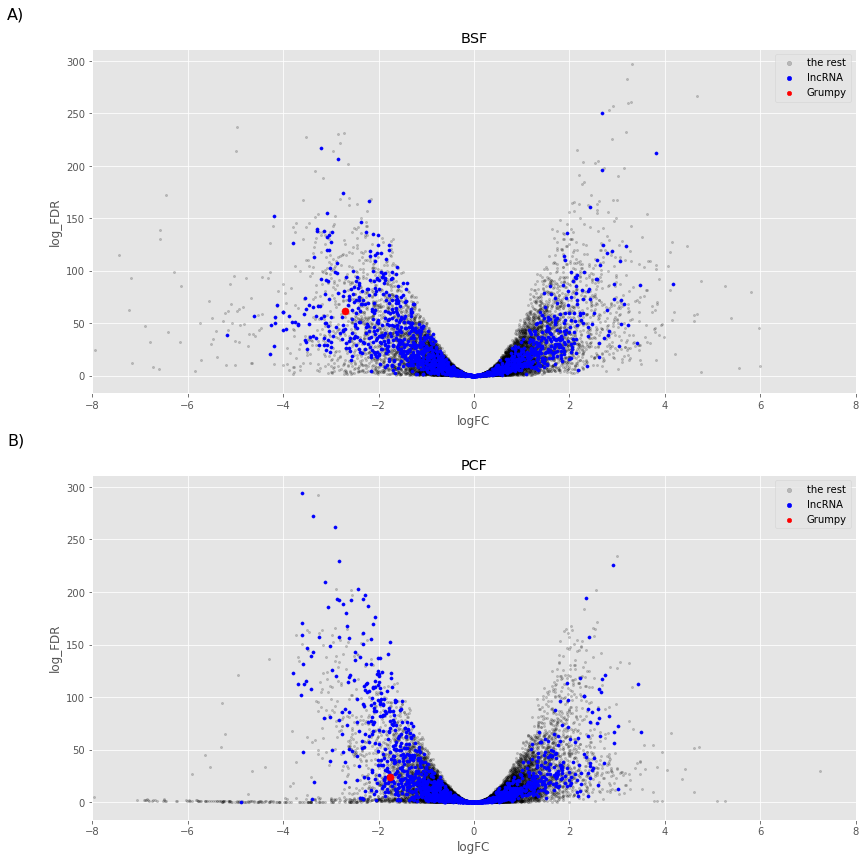

In [40]:
fig,axes=plt.subplots(figsize=(12,12),nrows=2)
grampy_VolcanoPlot(table_Bpol_v_Bsub,'BSF',axes[0],xlims=(-8,8))
grampy_VolcanoPlot(table_Ppol_v_Psub,'PCF',axes[1],xlims=(-8,8))
UT.set_fig_label(axes[0],'A')
UT.set_fig_label(axes[1],'B')
plt.tight_layout()
plt.savefig('Figures/Figure_13.png')

### average subpolysome/polysome

In [41]:
%%R
contrast_pol_v_sub <- glmLRT( fit_all, contrast=makeContrasts((groupPsub+groupBsub)/2-(groupPpol+groupBpol)/2,
                                                                levels=design_with_all ) )

table_pol_v_sub <- topTags(contrast_pol_v_sub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_pol_v_sub, n=20 )
#head(contrast_pol_v_sub)

Coefficient:  -0.5*groupBpol 0.5*groupBsub -0.5*groupPpol 0.5*groupPsub 
                   logFC   logCPM       LR PValue FDR
MSTRG.789      -3.831302 7.002021 1795.326      0   0
KS17gene_34a    3.342966 6.526367 1506.810      0   0
KS17gene_2065a  3.223701 6.568096 2315.324      0   0
Tb927.10.6060  -3.110074 5.966929 2293.877      0   0
Tb927.4.3870    3.065228 6.477057 1604.616      0   0
Tb927.11.6565   3.041247 5.412596 2374.398      0   0
KS17gene_2098a  3.011916 6.013919 1721.708      0   0
KS17gene_3178a  3.001652 5.993071 1958.771      0   0
Tb927.10.15040  2.973389 6.368807 1572.290      0   0
Tb927.8.6240   -2.822489 7.034526 1851.471      0   0
KS17gene_6722a  2.813124 6.593129 1862.661      0   0
KS17gene_3335a -2.797168 6.352484 1954.455      0   0
Tb927.4.3060   -2.759198 6.077982 2007.956      0   0
TRY.574        -2.708208 5.961843 1592.993      0   0
TRY.222        -2.656303 6.236804 1868.445      0   0
Tb927.10.1570  -2.654196 5.876790 2312.122      0   0
Tb927.3.5

In [42]:
%R -o table_pol_v_sub
table_pol_v_sub.head()
table_pol_v_sub['log_PValue'] = -np.log10(table_pol_v_sub['PValue'])
table_pol_v_sub['log_FDR'] = -np.log10(table_pol_v_sub['FDR'])


In [43]:
#table_pol_v_sub.loc['KS17gene_1749a']

## ANOVA Like

In [44]:
%%R
design_anova <- model.matrix(~group, data=y$samples)
fit <- glmQLFit(y, design_anova)
qlf <- glmQLFTest(fit, coef=2:6)
anova_like <- topTags(qlf, n=Inf, sort.by = "none", adjust.method="BH")$table
head(anova_like)

            logFC.groupBsub logFC.groupBtot logFC.groupPpol logFC.groupPsub
Tb927.8.150       1.0168289      -0.5845701       1.6287678       1.8273463
Tb927.8.230       1.1579856      -2.1255394       0.2730436      -4.9822596
Tb927.8.270       0.4951234      -0.4696762       0.1036485       0.6080619
Tb927.8.320       1.7963847      -1.9759712       2.8189071       3.0484253
Tb927.8.370       0.2656134      -1.3111274      -0.3519866      -2.3401828
Tb927.8.443       2.2652311       4.2783674       1.1053485       2.5972796
            logFC.groupPtot     logCPM         F       PValue          FDR
Tb927.8.150       1.5854941 -0.5119671 11.498249 7.566072e-05 8.320077e-05
Tb927.8.230      -0.9091797 -2.6243856  9.672533 3.612649e-04 3.853975e-04
Tb927.8.270      -0.3699495  4.1321009 42.066773 1.132596e-08 1.749348e-08
Tb927.8.320       1.7441628 -0.4844273 45.633470 6.204326e-09 9.972525e-09
Tb927.8.370      -0.2166172 -2.5063242  2.753317 5.563064e-02 5.629179e-02
Tb927.8.443       

In [45]:
%R -o anova_like
anova_like=anova_like[['F', 'PValue', 'FDR']]
anova_threshold = 1e-2
anova_like.shape,anova_like[anova_like['FDR']<anova_threshold].shape

((14389, 3), (14021, 3))

In [46]:
out_table.shape

(14389, 18)

In [47]:
#%%R
#library(HybridMTest)
#computed but not used for now
#anova_test <- row.oneway.anova(cpm_df, group)
#FDR1 <- p.adjust(anova_test$pval, "bonferroni")

In [48]:
#%R -o cpm_df,anova_test,FDR1,tt_Bsub_Bpol

In [49]:
#%R length(FDR1[FDR1 < 0.01])

In [50]:
out_df = out_table.copy()

In [51]:
out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.150,-1.852563,-1.712902,-2.234817,-1.013636,-1.295368,-1.584362,-0.057334,-0.421017,-0.451126,-0.673135,0.813578,0.643397,0.365831,-0.632863,0.942793,0.823503,0.966396,-0.121098
Tb927.8.230,-2.759846,-4.630386,-2.972667,-1.852563,-0.952375,-0.952375,-0.562241,-0.305454,0.065388,-0.841806,-0.012949,0.253248,0.587584,0.393757,1.136217,-0.305454,-0.673135,-3.084875
Tb927.8.270,3.393844,3.239970,3.087372,3.701112,3.834276,3.607020,4.154114,4.324114,4.151220,3.477283,3.250610,3.297918,3.908564,3.756117,3.802504,4.351514,4.221721,4.395912
Tb927.8.320,-3.444607,-3.120658,-3.056259,-1.295368,-0.952375,-1.295368,0.543643,0.942793,0.083219,-0.057334,1.149882,0.520393,1.824176,1.796042,1.136217,1.820284,2.330473,1.051405
Tb927.8.370,-1.584362,-1.852563,-3.622470,-0.517389,-2.021798,-0.562241,-0.421017,-0.892548,-0.952375,-0.673135,-0.421017,0.554783,0.379534,0.135419,0.908638,-0.713061,-1.013636,-2.021798


## RadViz - Signature in BSF SUB

In [52]:
#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

#from cqn These values are on the log2scale.        
radviz_dataset = np.exp(out_df).copy()

radviz_dataset=radviz_dataset[anova_like['FDR']<anova_threshold]
cols = list(radviz_dataset.columns)
#group coluns in cunk of 3 to compute the mean
col_grups = chunks(cols, 3)
for g in col_grups:
    base = '_'.join(g[0].split('_')[0:2])
    radviz_dataset[base]=radviz_dataset[g].median(axis=1)

#assign each gene to the class with max count

classes = radviz_dataset.iloc[:,18:].idxmax(axis=1)
#replace = {'B_pol':0, 'B_sub':1, 'B_tot':2, 'P_pol':3, 'P_sub':4, 'P_tot':5}
#classes = classes.replace(replace)
radviz_dataset=radviz_dataset.iloc[:,18:]
radviz_dataset['classes']=classes
radviz_dataset.head()

,B_tot,B_pol,B_sub,P_tot,P_pol,P_sub,classes
Tb927.8.150,0.156835,0.273797,0.656379,1.902934,1.441712,2.278466,P_sub
Tb927.8.230,0.051167,0.385824,0.736789,0.987135,1.799636,0.510107,P_pol
Tb927.8.270,25.532958,40.492319,63.695511,27.056245,44.813238,77.595836,P_sub
Tb927.8.320,0.044128,0.273797,1.722269,1.682689,6.025750,6.173609,P_sub
Tb927.8.443,123.944439,2.399242,20.763361,116.562219,6.270786,20.558183,B_tot


In [53]:
radviz_dataset.shape

(14021, 7)

### RadViz figure

B_sub
P_pol
P_tot
B_tot
P_sub
B_pol
['B_tot', 'P_tot', 'B_sub', 'P_sub', 'B_pol', 'P_pol']


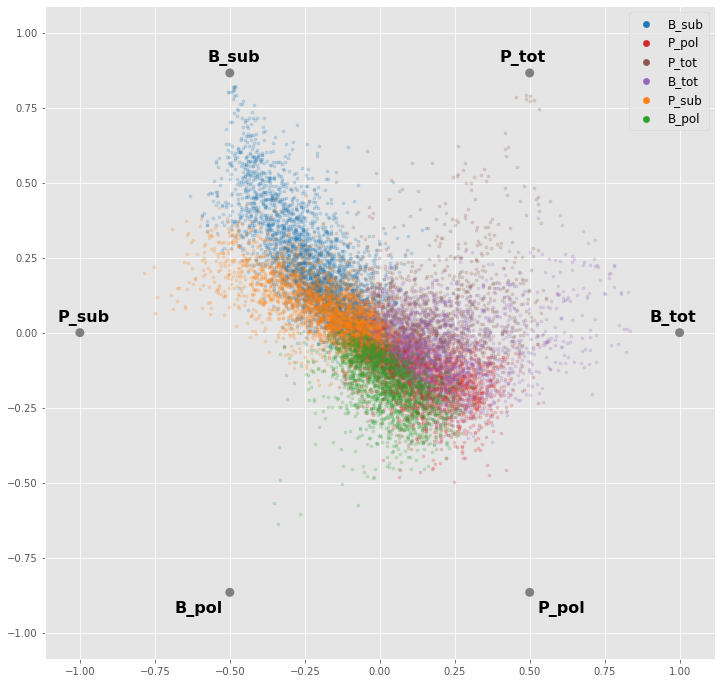

In [54]:
fig,ax=plt.subplots(figsize=(12,12))
cols = [n for n in out_df.columns if n.endswith('_mean')]
color = {'B_tot':'tab:purple','B_pol':'tab:green','B_sub':'tab:blue',
         'P_tot':'tab:brown','P_pol':'tab:red','P_sub':'tab:orange'}

radviz_dataset=radviz_dataset[['B_tot','P_tot','B_sub','P_sub','B_pol','P_pol','classes']]
rad_viz,to_plot,s = UT.radviz(radviz_dataset, 
                           'classes', color=color,ax=ax,)
plt.savefig('Figures/Figure_8.png')

## Cluster analysis

In [55]:
#mydata = out_df.iloc[:,:18]
#min_values = []
#for col in mydata:
#    min_values.append(mydata[col][mydata[col]>0].min())
#min_values
#del mydata


cluster_dataset=np.exp(out_df.iloc[:,:18])#+min_values
cluster_dataset.head()
cluster_dataset.describe()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
count,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000
mean,1435.559370,1435.500504,1435.534418,1435.617647,1435.617730,1435.613808,1435.854039,1435.942716,1435.965604,1435.804585,1435.971865,1435.961606,1436.164040,1436.113325,1436.067804,1435.945018,1435.960198,1435.823626
std,8309.325007,8309.334576,8309.328998,8309.314963,8309.314871,8309.315644,8309.276335,8309.262236,8309.258662,8309.284025,8309.255566,8309.257542,8309.224574,8309.232674,8309.239708,8309.261029,8309.258661,8309.282255
min,0.001714,0.008831,0.004023,0.009229,0.005307,0.025550,0.013944,0.011650,0.006525,0.010928,0.053669,0.068407,0.063224,0.056680,0.064830,0.065832,0.064612,0.007505
25%,138.315080,138.315080,138.315080,138.383666,138.383666,138.383666,138.827397,139.094011,139.027736,138.765443,138.765443,138.765443,139.277945,138.897284,138.958814,138.765443,138.701351,139.027736
50%,410.623223,410.623223,410.623223,410.623223,410.623223,410.623223,410.623223,410.623223,410.717218,410.623223,410.623223,410.623223,410.717218,410.717218,410.623223,410.623223,410.717218,410.623223
75%,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464,843.418464
max,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044,501836.345044


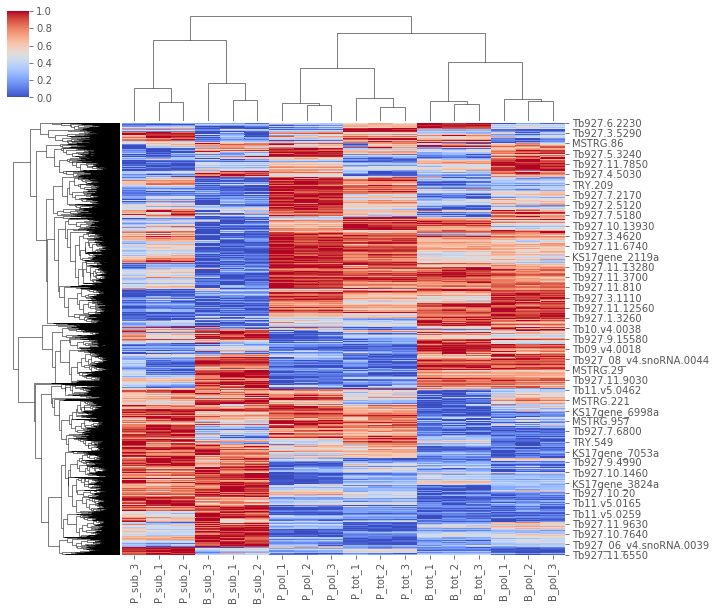

In [56]:
#%R -o anova_test,FDR
cluster_dataset=out_df.iloc[:,:18]
clustergrid = sns.clustermap(cluster_dataset[anova_like['FDR']<anova_threshold].sample(frac=0.3),
                             cmap=sns.color_palette("coolwarm", 256), 
                             standard_scale=0)


### Number of clusters

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


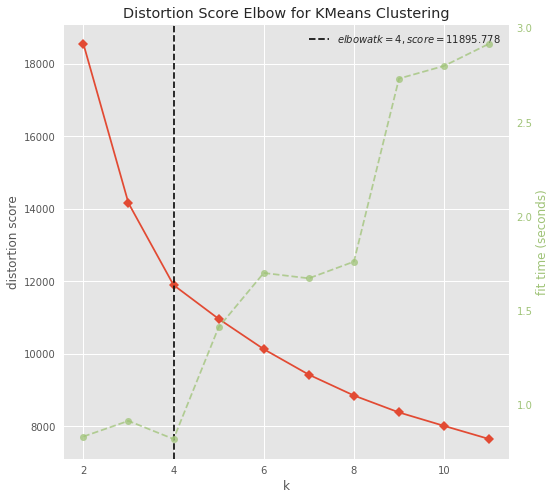

In [57]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
plt.style.use('ggplot')
X = UT.standard_scale(cluster_dataset[anova_like['FDR']<anova_threshold],0)
# Instantiate the clustering model and visualizer
model = KMeans()
fig, ax = plt.subplots(figsize=(8,8)) 
visualizer = KElbowVisualizer(model, k=(2,12),ax=ax)

visualizer.fit(X.values)        # Fit the data to the visualizer


visualizer.show(outpath="Figures/Figure_9.png")
#visualizer.show()


In [58]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
pd.Series(kmeans.labels_).value_counts()

2    4363
1    3529
3    3269
0    2860
dtype: int64

In [59]:
#from sklearn.cluster import SpectralBiclustering

#clustering = SpectralBiclustering(n_clusters=5,
#assign_labels="discretize",
#random_state=0).fit(X)
#pd.Series(clustering.labels_).value_counts()

### Cluster figure

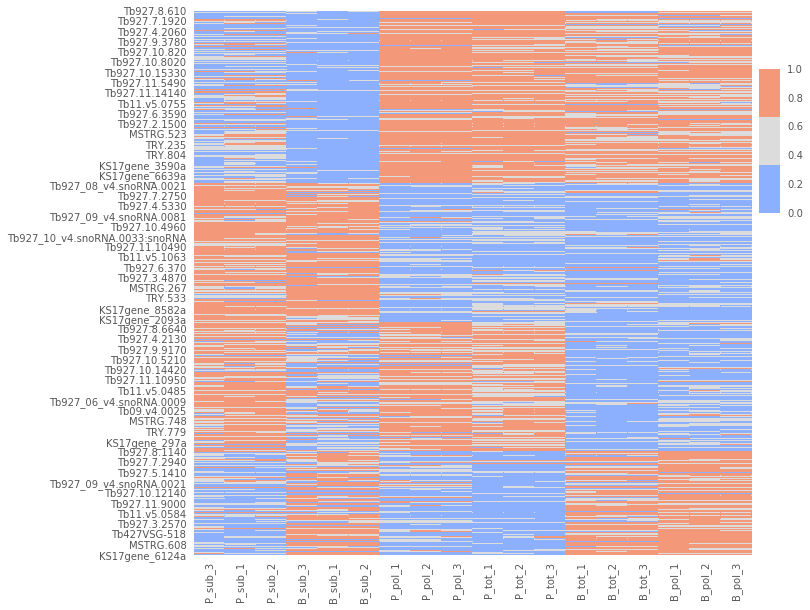

In [60]:
#res = TDdf[anova_test['FDR']<0.01]
X['label']=kmeans.labels_+1
#X['label']=X['label'].replace(dict_replace)
order = pd.Series(kmeans.labels_).value_counts().index.values

list_df = []
for n in order:
    list_df.append(X[X['label']==n+1])

final_list_df = []
for index,temp_df in enumerate(list_df):
    temp_df['label']=index+1
    final_list_df.append(temp_df)
    

X = pd.concat(final_list_df)


fig, ax = plt.subplots(figsize=(10,10))  
cbar_ax = fig.add_axes([.91, .6, .03, .2])
# Sample figsize in inches




sns.heatmap(X.iloc[:,0:-1].T.iloc[
    clustergrid.dendrogram_col.reordered_ind].T.astype(float),
            cmap=sns.color_palette("coolwarm", 3),
           ax=ax, cbar_ax = cbar_ax, cbar=True)

plt.savefig('Figures/Figure_10.png')

In [61]:
ks_lncRNA = open('InData/GS_gene_list.txt').read().split('\n')
X['is_ks']=[1 if n in ks_lncRNA else 0 for n in X.index.values]
len(ks_lncRNA)
X['is_ks'].value_counts()

0    12608
1     1413
Name: is_ks, dtype: int64

### Table lncRNA enrichment in clusters 


In [62]:
from scipy import stats


#k = np.arange(5)
#N = 52 # population size
#G = 4  # number of good elements in population
#n = 5  # simple random sample size
#stats.hypergeom.pmf(k, N, G, n)

population_size = X.shape[0]

for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['is_ks']==1) ].shape[0]
    population_sucess = X[X['is_ks']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=2.63e-03
_________
cluster 2: enrichment pvalue=3.62e-14
_________
cluster 3: enrichment pvalue=2.65e-02
_________
cluster 4: enrichment pvalue=7.05e-10
_________


### Cluster Table

In [63]:
X['desc']=[desc_dict.get(n,'none') for n in X.index.values]
X['H/ACA-like snoRNA']=[1 if 'H/ACA-like snoRNA' in n else 0 for n in X['desc']]
X['snoRNA']=[1 if 'snoRNA' in n else 0 for n in X.index.values]
X['Noncoding']=[1 if 'Noncoding RNA' in n else 0 for n in X['desc']]

### Table snoRNA

In [64]:
X.groupby('label')['snoRNA','H/ACA-like snoRNA','is_ks'].sum()

,snoRNA,H/ACA-like snoRNA,is_ks
label,,,
1,17,5,405
2,181,43,473
3,65,12,329
4,19,6,206


In [65]:
X.to_csv('Tables/Table_1.csv')

In [66]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['H/ACA-like snoRNA']==1) ].shape[0]
    population_sucess = X[X['H/ACA-like snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=3.34e-06
_________
cluster 2: enrichment pvalue=6.73e-12
_________
cluster 3: enrichment pvalue=7.55e-02
_________
cluster 4: enrichment pvalue=7.36e-03
_________


In [67]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['snoRNA']==1) ].shape[0]
    population_sucess = X[X['snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=1.01e-25
_________
cluster 2: enrichment pvalue=2.60e-44
_________
cluster 3: enrichment pvalue=5.66e-02
_________
cluster 4: enrichment pvalue=7.65e-11
_________


In [68]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['Noncoding']==1) ].shape[0]
    population_sucess = X[X['Noncoding']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=4.63e-06
_________
cluster 2: enrichment pvalue=1.47e-03
_________
cluster 3: enrichment pvalue=3.23e-07
_________
cluster 4: enrichment pvalue=1.97e-06
_________


## GO term Analysis

In [69]:
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
from goatools.associations import read_gaf

### Fix gaf file

In [70]:
import tqdm
replace_dict = {'P':'BP','F':'MF','C':'CC'}
def pars_trytripDB_gaf(infile):
    new_file = open(infile.replace('.gaf','2.gaf'),'w')
    for l in tqdm.tqdm(open(infile)):
        if l.startswith('!'):
            #new_file.write(l)
            continue
        else:    
            temp_list = l.split('\t')
            code = l.split('\t')[8]
            if code not in  replace_dict:
                continue
            temp_list[8] = replace_dict[code]
            new_file.write(temp_list[1]+'\t'+temp_list[4]+'\n')
    new_file.close()

pars_trytripDB_gaf('InData/TriTrypDB-46_TbruceiTREU927_GO.gaf')    

36000it [00:00, 319605.25it/s]


In [71]:
obo_fname = download_go_basic_obo()
in_go=os.path.join('InData/go-basic.obo')
obodag = GODag(in_go)
geneid2gos = read_associations('InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf')

  EXISTS: go-basic.obo
InData/go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms
HMS:0:00:00.085164  26,294 annotations READ: InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf 
**ERROR IdToGosReader(..., godag=None).get_id2gos: GODAG is None. IGNORING namespace(BP)

7683 IDs in all associations

In [72]:
out_df.shape,X.shape

((14389, 18), (14021, 24))

In [73]:
all_genes = out_df.index.values
print(len(all_genes))
goeaobj = GOEnrichmentStudy(
            list(all_genes), # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh'])

14389

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 51%  7,348 of 14,389 population items found in association


In [74]:
all_res = []
def analysis(data, cluster_id=0):
    geneids_study =  list(data[(data['label']==cluster_id)].index.values)
    geneids_study = [n for n in geneids_study if n in all_genes]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
    for item in goea_results_sig:
        item_list = str(item).split('\t')
        #print(item_list)
        tempres = [str(cluster_id), item_list[0], str(item_list[6]), item_list[1], item_list[3], item_list[4]]
        all_res.append('\t'.join(tempres))

for n in [1,2,3,4]:
    print(n,'_________________')
    analysis(X, cluster_id=n)

print(len(all_res))    
go_term_res = open('InData/goterm_enrich.txt','w')
go_term_res.write('\n'.join(all_res))
go_term_res.close()

1 _________________

Run GOEA Gene Ontology Analysis: current study set of 4363 IDs ... 57%  2,489 of  4,363 study items found in association
100%  4,363 of  4,363 study items found in population(14389)
Calculating 1,947 uncorrected p-values using fisher_scipy_stats
   1,947 GO terms are associated with  7,348 of 14,389 population items
   1,248 GO terms are associated with  2,489 of  4,363 study items
  METHOD fdr_bh:
      76 GO terms found significant (< 0.05=alpha) ( 64 enriched +  12 purified): statsmodels fdr_bh
   2,117 study items associated with significant GO IDs (enriched)
     126 study items associated with significant GO IDs (purified)
2 _________________

Run GOEA Gene Ontology Analysis: current study set of 3529 IDs ... 47%  1,671 of  3,529 study items found in association
100%  3,529 of  3,529 study items found in population(14389)
Calculating 1,947 uncorrected p-values using fisher_scipy_stats
   1,947 GO terms are associated with  7,348 of 14,389 population items
   

In [75]:
#pd.read_csv??

In [76]:
go_terms = pd.read_csv('InData/goterm_enrich.txt', sep='\t', header=None)
go_terms.columns = ['clusterID','goID','pvalue','goType','goDesc','found']
go_terms['found']=[int(n.split('/')[0]) for n in go_terms['found']]
go_terms['clusterID'] = ['C'+str(n) for n in go_terms['clusterID']]
print(go_terms.shape)
go_terms = go_terms[go_terms['found']>=2]
print(go_terms.shape)
del go_terms['found']
go_terms.head()

(61, 6)
(61, 6)


,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0051603,1.970000e-09,BP,proteolysis involved in cellular protein catab...
1,C1,GO:0010608,1.980000e-09,BP,posttranscriptional regulation of gene expression
2,C1,GO:0006950,5.470000e-08,BP,response to stress
3,C1,GO:0007018,2.210000e-07,BP,microtubule-based movement
4,C1,GO:0006511,4.930000e-06,BP,ubiquitin-dependent protein catabolic process


In [77]:
go_terms['clusterID'].value_counts()

C1    46
C4     8
C3     6
C2     1
Name: clusterID, dtype: int64

In [78]:
unique_go = go_terms.goID.value_counts()[go_terms.goID.value_counts()<=3].index.values
go_terms = go_terms[go_terms.goID.isin(unique_go)]
go_terms.head()

,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0051603,1.970000e-09,BP,proteolysis involved in cellular protein catab...
1,C1,GO:0010608,1.980000e-09,BP,posttranscriptional regulation of gene expression
2,C1,GO:0006950,5.470000e-08,BP,response to stress
3,C1,GO:0007018,2.210000e-07,BP,microtubule-based movement
4,C1,GO:0006511,4.930000e-06,BP,ubiquitin-dependent protein catabolic process


In [79]:
go_terms['clusterID'].value_counts()

C1    46
C4     8
C3     6
C2     1
Name: clusterID, dtype: int64

In [80]:
go_terms = go_terms[go_terms['clusterID']!='C1']

In [81]:
#vizGo = pd.pivot_table(go_terms, index='goID',columns['clusterID'])#.reset_index()
vizGo = pd.pivot_table(go_terms, index='goDesc', columns=['clusterID'])
vizGo = -np.log10(vizGo)
vizGo=vizGo.fillna(0)
print(vizGo.head())
vizGo.columns = ['C2','C3','C4']
vizGo =vizGo.sort_values(['C2','C3','C4'])
vizGo.head()

                                              pvalue                    
clusterID                                         C2        C3        C4
goDesc                                                                  
S-adenosylmethionine biosynthetic process   0.000000  0.000000  6.319664
cell surface                                0.000000  0.000000  5.636388
evasion of host immune response             0.000000  7.162412  0.000000
integral component of membrane              0.000000  0.000000  8.080399
mRNA binding                               11.920819  0.000000  0.000000


,C2,C3,C4
goDesc,,,
cell surface,0.0,0.000000,5.636388
S-adenosylmethionine biosynthetic process,0.0,0.000000,6.319664
methionine adenosyltransferase activity,0.0,0.000000,6.319664
integral component of membrane,0.0,0.000000,8.080399
translation,0.0,4.943095,5.782516


In [82]:
vizGo.tail()

,C2,C3,C4
goDesc,,,
ribosome,0.000000,7.092051,5.669586
structural constituent of ribosome,0.000000,7.120904,6.411168
evasion of host immune response,0.000000,7.162412,0.000000
mitochondrion,0.000000,10.363512,5.490797
mRNA binding,11.920819,0.000000,0.000000


### GO term Figure

(10.5, 0.5)


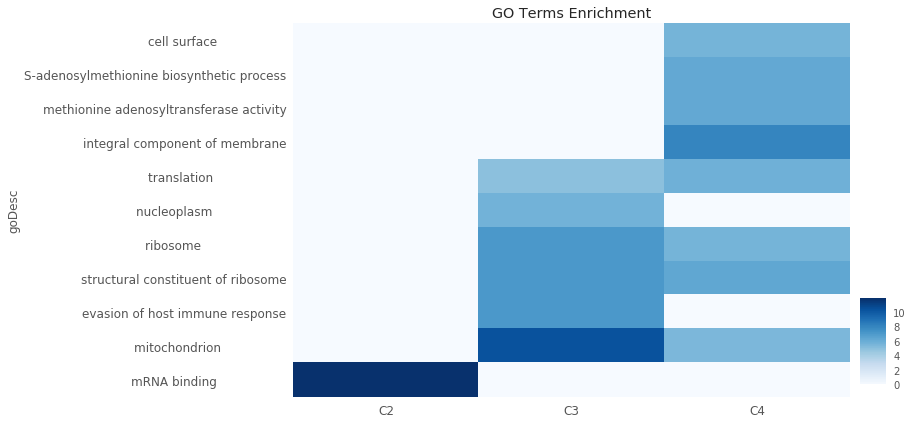

In [83]:
#del vizGo['C1']
fig, ax = plt.subplots(figsize=(12,6))  
cbar_ax = fig.add_axes([1, .1, .03, .2])
# Sample figsize in inches
sns.heatmap(vizGo,
            cmap=sns.color_palette("Blues", 128),
           ax=ax, cbar_ax = cbar_ax, cbar=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('GO Terms Enrichment')
print(ax.get_ylim())
ax.set_ylim(ax.get_ylim()[0]+0.5, 0)
plt.tight_layout()
plt.savefig('Figures/Figure_11.png')
plt.show()

## mRNA Half Life

In [84]:
pcf_hl = pd.read_csv('InData/mRNA_Half_Life/mrnaPCFhl.txt',sep='\t',index_col=[0])
bsf_hl = pd.read_csv('InData/mRNA_Half_Life/mrnaBSFhl.txt',sep='\t',index_col=[0])
hl = pcf_hl.join(bsf_hl,how='outer')
hl=hl.reset_index()
hl_lookup = pd.read_csv('InData/mRNA_Half_Life//mRNAhl_lookup.txt',sep='\t',index_col=[0])
hl_df = hl_lookup.merge(hl,left_on='Input ID',right_on='Gene_ID',how='outer')
hl_df.set_index('Gene_ID',inplace=True)
hl_df=hl_df.join(X,how='left')
del hl_df['Unnamed: 6']
#hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']
hl_df.head()

,Organism,Genomic Location (Gene),Product Description,Gene Type,Input ID,PCF_half-life,BSF_half-life,B_tot_1,B_tot_2,B_tot_3,...,P_pol_3,P_sub_1,P_sub_2,P_sub_3,label,is_ks,desc,H/ACA-like snoRNA,snoRNA,Noncoding
Tb927.1.1020,T. brucei brucei TREU927,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,10.0,13.62,0.017188,0.000000,0.181165,...,0.818826,0.697201,0.710539,1.000000,3.0,0.0,leucine-rich repeat-containing protein,0.0,0.0,0.0
Tb927.1.1030,T. brucei brucei TREU927,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,10.0,7.91,0.000000,0.027550,0.064131,...,0.326293,0.625090,0.661988,0.709407,2.0,0.0,Nucleolar protein 49,0.0,0.0,0.0
Tb927.1.1040,NaN,NaN,NaN,NaN,NaN,NaN,6.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.1.1080,T. brucei brucei TREU927,"Tb927_01_v5.1:305,834..307,362(+)","TFIIH basal transcription factor subunit, puta...",protein coding,Tb927.1.1080,7.0,7.38,0.810700,0.579138,0.595687,...,0.176842,0.955471,0.918958,1.000000,2.0,0.0,TFIIH basal transcription factor subunit puta...,0.0,0.0,0.0
Tb927.1.1120,T. brucei brucei TREU927,"Tb927_01_v5.1:312,383..313,566(+)","ribosomal RNA-processing protein 8, putative",protein coding,Tb927.1.1120,10.0,8.97,0.274609,0.139307,0.232892,...,0.903298,0.633208,0.621796,0.550967,3.0,0.0,ribosomal RNA-processing protein 8 putative,0.0,0.0,0.0


In [85]:
#for col in ['PCF_half-life','BSF_half-life']:
#    col_zscore = col + '_zscore'
#    hl_df[col_zscore] =((hl_df[col] - hl_df[col].mean())/hl_df[col].std(ddof=0)).values

#hl_df['hl_dif_zscore']=hl_df['BSF_half-life_zscore']-hl_df['PCF_half-life_zscore']    
#hl_df.groupby('label')[['PCF_half-life_zscore','BSF_half-life_zscore','hl_dif_zscore']].mean()

### Table mRNA half life

In [86]:
hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']    
hl_df.groupby('label')[['PCF_half-life','BSF_half-life','hl_dif']].median().sort_values('hl_dif')

,PCF_half-life,BSF_half-life,hl_dif
label,,,
1.0,27.0,14.39,0.490635
3.0,20.0,10.84,0.493684
2.0,15.0,10.58,0.634167
4.0,17.0,11.37,0.646000


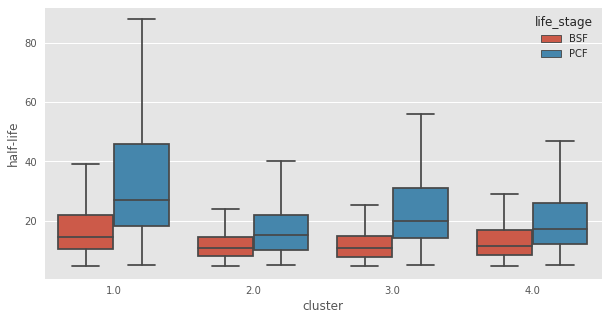

In [87]:
temp1 = hl_df[['BSF_half-life','label']]
temp1.columns = ['half-life','cluster']
temp1['life_stage']='BSF'
temp2 = hl_df[['PCF_half-life','label']]
temp2.columns = ['half-life','cluster']
temp2['life_stage']='PCF'
dataset_hl = pd.concat([temp1,temp2])

fig, ax = plt.subplots(figsize=(10,5))  
sns.boxplot(data=dataset_hl,x='cluster',
            y='half-life',hue='life_stage',
            showfliers=False,ax=ax)
plt.savefig('Figures/Figure_12.png')
plt.show()

In [88]:
dataset_hl.groupby(['cluster','life_stage'])['half-life'].mean().sort_values()

cluster  life_stage
2.0      BSF           12.380072
3.0      BSF           12.975223
4.0      BSF           14.361297
1.0      BSF           17.928982
2.0      PCF           18.930426
4.0      PCF           21.846154
3.0      PCF           26.610860
1.0      PCF           36.658974
Name: half-life, dtype: float64

## Finding new protein coding genes

In [89]:
!gtf2bed < 'tb927_3_ks_st_sc_st_tr.gtf' > 'tb927_3_ks_st_sc_st_tr.bed'
!sort-bed < 'tb927_3_ks_st_sc_st_tr.bed' - > 'tb927_3_ks_st_sc_st_tr_sorted.bed'
outfile = open('tb927_3_ks_st_sc_st_tr_sorted_filter.bed','w')
for line in open('tb927_3_ks_st_sc_st_tr_sorted.bed'):
    if 'KS17' in line:
        outfile.write(line)
    elif 'MSTRG' in line:
        outfile.write(line)
    elif 'TRY.' in line:
        outfile.write(line)
    else:
        pass
outfile.close()

### process proteomics

In [90]:
def process_peps(infile='proteomics/CDS/peptides.zip'):
    bsf_cds_pep = pd.read_csv(infile,sep='\t', usecols=
                              ['Proteins','Reverse','Potential contaminant',
                              'Start position', 'Sequence', 'End position'])
    bsf_cds_pep['Proteins'] =bsf_cds_pep['Proteins'].astype(str)
    bsf_cds_pep['Reverse'] = bsf_cds_pep['Reverse'].astype(str)
    bsf_cds_pep = bsf_cds_pep[bsf_cds_pep['Reverse'] != '+' ]
    bsf_cds_pep['Potential contaminant'] = bsf_cds_pep['Potential contaminant'].astype(str)
    bsf_cds_pep = bsf_cds_pep[bsf_cds_pep['Potential contaminant'] != '+' ]
    del bsf_cds_pep['Potential contaminant']
    bsf_cds_pep['my_name'] = [n.split(';')[0] for n in bsf_cds_pep['Proteins']]
    bsf_cds_pep['my_chro'] = [n.split('-')[0] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_frame'] = [n.split('-')[1] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_start'] = [n.split('-')[2] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_end'] = [n.split('-')[3] for n in bsf_cds_pep['my_name']]

    bsf_cds_pep['my_start']=bsf_cds_pep['my_start'].astype(int)
    bsf_cds_pep['my_end']=bsf_cds_pep['my_end'].astype(int)

    bsf_cds_pep['dif'] = bsf_cds_pep['my_start']-bsf_cds_pep['my_end']
    bsf_cds_pep['new_start'] = bsf_cds_pep[['my_start','my_end']].min(axis=1).astype(int)
    bsf_cds_pep['new_end'] = bsf_cds_pep[['my_start','my_end']].max(axis=1).astype(int)
    return bsf_cds_pep

bsf_cds_pep =  process_peps(infile='InData/Proteomics/peptides_bsf_trim.zip')
pcf_cds_pep = process_peps(infile='InData/Proteomics/peptides_pcf_trim.zip')

In [91]:
(586011-586068)/3

-19.0

In [92]:
bsf_cds_pep.head()
bsf_cds_pep['life_stage']='BSF'
pcf_cds_pep['life_stage']='PCF'

In [93]:
bsf_cds_pep=pd.concat([bsf_cds_pep,pcf_cds_pep])

In [94]:
bsf_cds_pep[bsf_cds_pep['Sequence']=='YLNFGNAADFTDGYGMVIR']

,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage
78036,YLNFGNAADFTDGYGMVIR,Tb927_02_v5.1-1-246664-247455;Tb927_11_bin_v5....,505.0,523.0,nan,Tb927_02_v5.1-1-246664-247455,Tb927_02_v5.1,1,246664,247455,-791,246664,247455,BSF
59269,YLNFGNAADFTDGYGMVIR,Tb927_11_bin_v5.1-2-3629708-3631792;Tb927_02_v...,505.0,523.0,nan,Tb927_11_bin_v5.1-2-3629708-3631792,Tb927_11_bin_v5.1,2,3629708,3631792,-2084,3629708,3631792,PCF


In [95]:
neg_dif = bsf_cds_pep[bsf_cds_pep['dif']<1]
neg_dif['pep_start'] = (neg_dif['Start position']*3)+neg_dif['my_start']-3
neg_dif['pep_end'] = neg_dif['pep_start']+(neg_dif['Sequence'].str.len() *3)-1
neg_dif.head()

,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage,pep_start,pep_end
0,AAAAAAAAEVESGIAGVEETLR,Tb927_05_v5.1-3-586011-591284,20.0,41.0,nan,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,3,586011,591284,-5273,586011,591284,BSF,586068.0,586133.0
1,AAAAAAAAEVESGIAGVEETLRR,Tb927_05_v5.1-3-586011-591284,20.0,42.0,nan,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,3,586011,591284,-5273,586011,591284,BSF,586068.0,586136.0
2,AAAAAFQESVGR,Tb927_08_v5.1-1-1802833-1806903,612.0,623.0,nan,Tb927_08_v5.1-1-1802833-1806903,Tb927_08_v5.1,1,1802833,1806903,-4070,1802833,1806903,BSF,1804666.0,1804701.0
5,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,Tb927_01_v5.1-3-717978-720599,364.0,393.0,nan,Tb927_01_v5.1-3-717978-720599,Tb927_01_v5.1,3,717978,720599,-2621,717978,720599,BSF,719067.0,719156.0
6,AAAADCAADGRLDEAVDLLAQALR,Tb927_03_v5.1-3-1499100-1500287,116.0,139.0,nan,Tb927_03_v5.1-3-1499100-1500287,Tb927_03_v5.1,3,1499100,1500287,-1187,1499100,1500287,BSF,1499445.0,1499516.0


In [96]:
pos_dif = bsf_cds_pep[bsf_cds_pep['dif']>1]
pos_dif.head()
pos_dif['pep_end'] = pos_dif['my_start'] -(pos_dif['End position']*3)+1
pos_dif['pep_start']=pos_dif['pep_end']+(pos_dif['Sequence'].str.len() *3)-1
#pos_dif['pep_end'] = pos_dif['pep_start']+(pos_dif['Sequence'].str.len() *3)-1
#1332964
pos_dif.head()


,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage,pep_end,pep_start
3,AAAAATISGAVPMHSLQASGGHASGADDSTCER,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,426.0,458.0,nan,Tb927_11_bin_v5.1-6-1334239-1332284,Tb927_11_bin_v5.1,6,1334239,1332284,1955,1332284,1334239,BSF,1332866.0,1332964.0
4,AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,426.0,464.0,nan,Tb927_11_bin_v5.1-6-1334239-1332284,Tb927_11_bin_v5.1,6,1334239,1332284,1955,1332284,1334239,BSF,1332848.0,1332964.0
8,AAAADTSTASETEDVFANQPEAMK,Tb927_05_v5.1-4-1050101-1048047,92.0,115.0,nan,Tb927_05_v5.1-4-1050101-1048047,Tb927_05_v5.1,4,1050101,1048047,2054,1048047,1050101,BSF,1049757.0,1049828.0
10,AAAAELGLHIGIALDTK,Tb927_10_v5.1-5-3436188-3434638;Tb927_11_bin_v...,88.0,104.0,nan,Tb927_10_v5.1-5-3436188-3434638,Tb927_10_v5.1,5,3436188,3434638,1550,3434638,3436188,BSF,3435877.0,3435927.0
13,AAAAFPQPTGLAHR,Tb927_07_v5.1-5-1174114-1172807,67.0,80.0,nan,Tb927_07_v5.1-5-1174114-1172807,Tb927_07_v5.1,5,1174114,1172807,1307,1172807,1174114,BSF,1173875.0,1173916.0


In [97]:
bsf_cds_pep=pd.concat([neg_dif,pos_dif])
bsf_cds_pep.head()

,End position,Proteins,Reverse,Sequence,Start position,dif,life_stage,my_chro,my_end,my_frame,my_name,my_start,new_end,new_start,pep_end,pep_start
0,41.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586133.0,586068.0
1,42.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLRR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586136.0,586068.0
2,623.0,Tb927_08_v5.1-1-1802833-1806903,nan,AAAAAFQESVGR,612.0,-4070,BSF,Tb927_08_v5.1,1806903,1,Tb927_08_v5.1-1-1802833-1806903,1802833,1806903,1802833,1804701.0,1804666.0
5,393.0,Tb927_01_v5.1-3-717978-720599,nan,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,364.0,-2621,BSF,Tb927_01_v5.1,720599,3,Tb927_01_v5.1-3-717978-720599,717978,720599,717978,719156.0,719067.0
6,139.0,Tb927_03_v5.1-3-1499100-1500287,nan,AAAADCAADGRLDEAVDLLAQALR,116.0,-1187,BSF,Tb927_03_v5.1,1500287,3,Tb927_03_v5.1-3-1499100-1500287,1499100,1500287,1499100,1499516.0,1499445.0


In [98]:
bsf_cds_pep['names'] = (bsf_cds_pep['my_chro']+'_'+
                        bsf_cds_pep['pep_start'].astype(int).astype(str)+'_'+
                        bsf_cds_pep['pep_end'].astype(int).astype(str)+'_'+
                        bsf_cds_pep['Sequence']+'_'+
                       bsf_cds_pep['life_stage'])

In [99]:
#bsf_cds_pep.head()

In [100]:
bsf_cds_pep[['my_chro','pep_start','pep_end','names','Sequence']]
#bsf_cds_pep['pep_end'].describe()
#bsf_cds_pep.rename({'pep_start':'pep_start2'},{'pep_end':'pep_end2'})


,my_chro,pep_start,pep_end,names,Sequence
0,Tb927_05_v5.1,586068.0,586133.0,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...,AAAAAAAAEVESGIAGVEETLR
1,Tb927_05_v5.1,586068.0,586136.0,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...,AAAAAAAAEVESGIAGVEETLRR
2,Tb927_08_v5.1,1804666.0,1804701.0,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF,AAAAAFQESVGR
5,Tb927_01_v5.1,719067.0,719156.0,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK
6,Tb927_03_v5.1,1499445.0,1499516.0,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...,AAAADCAADGRLDEAVDLLAQALR
...,...,...,...,...,...
60404,Tb927_04_v5.1,517365.0,517333.0,Tb927_04_v5.1_517365_517333_YYVESQEELRK_PCF,YYVESQEELRK
60405,Tb927_10_v5.1,3591227.0,3591204.0,Tb927_10_v5.1_3591227_3591204_YYVLEIDR_PCF,YYVLEIDR
60406,Tb927_03_v5.1,181431.0,181405.0,Tb927_03_v5.1_181431_181405_YYVNGGCLR_PCF,YYVNGGCLR
60408,Tb927_10_v5.1,2039578.0,2039519.0,Tb927_10_v5.1_2039578_2039519_YYVSPVVHVSMPTGTL...,YYVSPVVHVSMPTGTLAVIT


In [101]:
bsf_cds_pep['pep_start2']=bsf_cds_pep['pep_start'].astype(int)
bsf_cds_pep['pep_end2']=bsf_cds_pep['pep_end'].astype(int)

In [102]:
right = bsf_cds_pep[bsf_cds_pep['pep_start2']<bsf_cds_pep['pep_end2']]
wrong = bsf_cds_pep[bsf_cds_pep['pep_start2']>bsf_cds_pep['pep_end2']]
wrong['temp1'] = wrong['pep_start2']
wrong['temp2'] = wrong['pep_end2'] 
wrong['pep_start2']=wrong['temp2']
wrong['pep_end2']=wrong['temp1']
del wrong['temp2']
del wrong['temp1']
bsf_cds_pep = pd.concat([right,wrong])
bsf_cds_pep.head()

,End position,Proteins,Reverse,Sequence,Start position,dif,life_stage,my_chro,my_end,my_frame,my_name,my_start,new_end,new_start,pep_end,pep_start,names,pep_start2,pep_end2
0,41.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586133.0,586068.0,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...,586068,586133
1,42.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLRR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586136.0,586068.0,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...,586068,586136
2,623.0,Tb927_08_v5.1-1-1802833-1806903,nan,AAAAAFQESVGR,612.0,-4070,BSF,Tb927_08_v5.1,1806903,1,Tb927_08_v5.1-1-1802833-1806903,1802833,1806903,1802833,1804701.0,1804666.0,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF,1804666,1804701
5,393.0,Tb927_01_v5.1-3-717978-720599,nan,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,364.0,-2621,BSF,Tb927_01_v5.1,720599,3,Tb927_01_v5.1-3-717978-720599,717978,720599,717978,719156.0,719067.0,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...,719067,719156
6,139.0,Tb927_03_v5.1-3-1499100-1500287,nan,AAAADCAADGRLDEAVDLLAQALR,116.0,-1187,BSF,Tb927_03_v5.1,1500287,3,Tb927_03_v5.1-3-1499100-1500287,1499100,1500287,1499100,1499516.0,1499445.0,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...,1499445,1499516


In [103]:
bsf_cds_pep = bsf_cds_pep[['my_chro','pep_start2','pep_end2','names']]
bsf_cds_pep = bsf_cds_pep[(bsf_cds_pep['pep_start2']>0)&(bsf_cds_pep['pep_end2']>0)]

bsf_cds_pep.to_csv('pep_cds.bed', header=False, index=False,sep='\t')
bsf_cds_pep.head(5)

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF
5,Tb927_01_v5.1,719067,719156,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...
6,Tb927_03_v5.1,1499445,1499516,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...


In [104]:
bsf_cds_pep['pep_start2']=bsf_cds_pep['pep_start2'].astype(int)
bsf_cds_pep['pep_end2']=bsf_cds_pep['pep_end2'].astype(int)
bsf_cds_pep.head()

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF
5,Tb927_01_v5.1,719067,719156,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...
6,Tb927_03_v5.1,1499445,1499516,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...


In [105]:
bsf_cds_pep.head()

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF
5,Tb927_01_v5.1,719067,719156,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...
6,Tb927_03_v5.1,1499445,1499516,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...


### Create pep track

In [106]:
bsf_cds_pep['dummy']=1
bsf_cds_pep[['my_chro','pep_start2','pep_end2','dummy']
           ].to_csv('all_pepe.bed',index=False,header=False,sep='\t')

In [107]:
list(pd.read_csv('pep_cds.bed',sep='\t',header=None).iloc[68359:68362,3])

['Tb927_11_bin_v5.1_1332964_1332866_AAAAATISGAVPMHSLQASGGHASGADDSTCER_BSF',
 'Tb927_11_bin_v5.1_1332964_1332848_AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK_BSF',
 'Tb927_05_v5.1_1049828_1049757_AAAADTSTASETEDVFANQPEAMK_BSF']

### find novel protein coding genes

In [108]:
#!sortBed -i 'pep_cds.bed' > 'pep_cds_sorted.bed'

In [109]:
!sort-bed < 'pep_cds.bed' - > 'pep_cds_sorted.bed'

In [110]:
!bedextract  'pep_cds_sorted.bed' tb927_3_ks_st_sc_st_tr_sorted_filter.bed > cds.filtered.bed

In [111]:
!bedtools intersect -wo -a tb927_3_ks_st_sc_st_tr_sorted_filter.bed \
                             -b cds.filtered.bed  > cds.filtered_closest2.bed

In [112]:
innew = pd.read_table('cds.filtered_closest2.bed',header=None)
innew.columns = [
    'chro','start','end','name','score','score2',
    'ref','gene_feature','score3','gene_ref',
    'chro2','pep_start','pep_end','pep_ref','pep_size'
]
innew=innew[innew['gene_feature']=='transcript']
print(innew.groupby('name').size().shape)
innew.groupby('name').size()

(101,)


name
KS17gene_1150a     1
KS17gene_1625a     1
KS17gene_1743a     2
KS17gene_1898a     3
KS17gene_2001a     1
                  ..
TRY.854           15
TRY.862            5
TRY.871            3
TRY.878           10
TRY.884           32
Length: 101, dtype: int64

In [113]:
main_chrs = ['Tb927_{}_v5.1'.format(c) for c in ['01','02','03','04','05','06','07','08','09','10','11']]

innew[innew['chro'].isin(main_chrs)].groupby(['chro','name']).size()

chro           name          
Tb927_02_v5.1  KS17gene_245a     9
               KS17gene_265a     4
               KS17gene_4445a    3
               MSTRG.102         4
               MSTRG.94          3
Tb927_03_v5.1  KS17gene_4643a    1
Tb927_04_v5.1  KS17gene_4953a    1
Tb927_06_v5.1  KS17gene_1150a    1
               MSTRG.191         1
Tb927_07_v5.1  KS17gene_1625a    1
               MSTRG.240         3
               TRY.375           2
Tb927_08_v5.1  KS17gene_1743a    2
               KS17gene_1898a    3
               KS17gene_2001a    1
               KS17gene_2052a    4
               KS17gene_6275a    1
               KS17gene_6299a    1
               KS17gene_6391a    1
Tb927_09_v5.1  KS17gene_2249a    1
               KS17gene_2334a    5
               KS17gene_2338a    1
               KS17gene_6998a    2
               KS17gene_7003a    6
Tb927_10_v5.1  KS17gene_2781a    1
               KS17gene_2782a    1
               MSTRG.443         1
               TRY.736   

In [114]:
print(innew[innew['chro'].isin(main_chrs)].groupby('name').size().shape)
innew[innew['chro'].isin(main_chrs)].groupby('name').size()

(30,)


name
KS17gene_1150a    1
KS17gene_1625a    1
KS17gene_1743a    2
KS17gene_1898a    3
KS17gene_2001a    1
KS17gene_2052a    4
KS17gene_2249a    1
KS17gene_2334a    5
KS17gene_2338a    1
KS17gene_245a     9
KS17gene_265a     4
KS17gene_2781a    1
KS17gene_2782a    1
KS17gene_4445a    3
KS17gene_4643a    1
KS17gene_4953a    1
KS17gene_6275a    1
KS17gene_6299a    1
KS17gene_6391a    1
KS17gene_6998a    2
KS17gene_7003a    6
KS17gene_8114a    1
KS17gene_8518a    4
MSTRG.102         4
MSTRG.191         1
MSTRG.240         3
MSTRG.443         1
MSTRG.94          3
TRY.375           2
TRY.736           1
dtype: int64

In [115]:
innew['dummy']=1
innew[['chro2','pep_start','pep_end','dummy']].to_csv('new_genes.bed',index=False,header=False,sep='\t')

In [116]:
innew.to_csv('predicted_new_pep.csv')

In [117]:
from Bio import SeqIO
from Bio.Seq import Seq

chr_dict = {}
fasta_sequences = SeqIO.parse(open('InData/tb927_5.fa'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    chr_dict[name]=sequence
    
def get_seq(X, chr_dict):
    temp_seq = chr_dict[X['ref_chro']]
    temp_seq = temp_seq[X['ref_start']+1:X['ref_end']]
    return temp_seq

## Find closest 5'

In [118]:
def get_gene(indata):
    indata = indata[-1].split(';')
    res = {}
    #print(indata)
    for n in indata:
        if 'gene_id' in n:
            n=n.strip()
            res[n.split(' ')[0].strip()]=n.split(' ')[1].strip('\"').strip('\'').strip()
    #print(res)
    return res['gene_id']

inbed = pd.read_csv('tb927_3_ks_st_sc_st_tr_sorted.bed',sep='\t')
inbed.columns = ['chro','start','end','gene_id','a','orient','source','ftype','e','f']
inbed=inbed[inbed['ftype']=='transcript']
inbed =inbed.reset_index()
del inbed['index']
#inbed =inbed.reset_index()
#inbed = inbed.set_index('gene_id')
inbed['gene_plus1'] = inbed['gene_id'].shift(+1)
inbed['gene_plus2'] = inbed['gene_id'].shift(+2)
inbed['orient_plus1'] = inbed['orient'].shift(+1)
inbed['orient_plus2'] = inbed['orient'].shift(+2)
inbed['gene_minus1'] = inbed['gene_id'].shift(-1)
inbed['orient_minus1'] = inbed['orient'].shift(-1)
inbed['gene_minus2'] = inbed['gene_id'].shift(-2)
inbed['orient_minus2'] = inbed['orient'].shift(-2)
inbed.head()

,chro,start,end,gene_id,a,orient,source,ftype,e,f,gene_plus1,gene_plus2,orient_plus1,orient_plus2,gene_minus1,orient_minus1,gene_minus2,orient_minus2
0,11L3_v3,0,2768,MSTRG.1,1000,.,StringTie,transcript,.,"gene_id ""MSTRG.1""; transcript_id ""MSTRG.1.1"";",NaN,NaN,NaN,NaN,MSTRG.2,.,TRY.1,-
1,11L3_v3,3000,5482,MSTRG.2,1000,.,StringTie,transcript,.,"gene_id ""MSTRG.2""; transcript_id ""MSTRG.2.1"";",MSTRG.1,NaN,.,NaN,TRY.1,-,TRY.2,-
2,11L3_v3,5482,6228,TRY.1,1000,-,StringTie,transcript,.,"gene_id ""TRY.1""; transcript_id ""TRY.1.1"";",MSTRG.2,MSTRG.1,.,.,TRY.2,-,TRY.3,-
3,11L3_v3,6598,8129,TRY.2,1000,-,StringTie,transcript,.,"gene_id ""TRY.2""; transcript_id ""TRY.2.1"";",TRY.1,MSTRG.2,-,.,TRY.3,-,MSTRG.3,.
4,11L3_v3,8332,9722,TRY.3,1000,-,StringTie,transcript,.,"gene_id ""TRY.3""; transcript_id ""TRY.3.1"";",TRY.2,TRY.1,-,-,MSTRG.3,.,TRY.4,-


In [119]:
for_list = inbed[(inbed['orient_minus1']=='+')#&
     #inbed['gene_id'].isin(common_genes)&
     #inbed['gene_minus1'].str.startswith('Tb')
                
                ][['gene_id','gene_minus1','orient_minus1']]

rev_list = inbed[(inbed['orient_plus1']=='-')#&
#      inbed['gene_id'].isin(common_genes)&
     #inbed['gene_plus1'].str.startswith('Tb')
                
                ][['gene_id','gene_plus1','orient_plus1']]
rev_list.columns = ['gene_id','reg_gene','orient']
for_list.columns = ['gene_id','reg_gene','orient']
merge_list = pd.concat([for_list,rev_list])


In [120]:
print(merge_list.shape)
merge_list.tail()

(14857, 3)


,gene_id,reg_gene,orient
15841,Tb11.1600,Tb11.1590,-
15842,Tb11.1630,Tb11.1600,-
15847,Tb11.1680,Tb11.1670,-
15848,MSTRG.999,Tb11.1680,-
15868,MSTRG.1012,Tb11.1800,-


### BSF and PCF

In [121]:
table_pol_v_sub.loc[['KS17gene_1749a','KS17gene_4295a','KS17gene_3137a']]

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR
KS17gene_1749a,1.087241,6.140075,419.952053,2.499669e-93,2.967636e-92,92.602117,91.527589
KS17gene_4295a,0.152605,1.374800,0.983221,3.214049e-01,3.495084e-01,0.492948,0.456542
KS17gene_3137a,2.230830,3.073615,369.012491,3.070479e-82,2.941487e-81,81.512794,80.531433


In [122]:
regulatory_df = merge_list[
    (merge_list['gene_id'].str.startswith('KS')#)|
    #(merge_list['gene_id'].str.startswith('TRY.'))|
    #(merge_list['gene_id'].str.startswith('MSTRG.')
    )
].drop_duplicates('gene_id').set_index('gene_id').join(
    table_pol_v_sub,how='inner').reset_index().rename({'index':'gene_id'},axis=1).drop_duplicates(
    'reg_gene').set_index('reg_gene').join(table_pol_v_sub,how='inner',rsuffix='_reg').reset_index(
).rename({'index':'reg_gene'},axis=1).set_index('gene_id')

regulatory_df = regulatory_df[regulatory_df['reg_gene'].str.startswith('Tb')]


In [123]:
regulatory_df.head()

,reg_gene,orient,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,logFC_reg,logCPM_reg,LR_reg,PValue_reg,FDR_reg,log_PValue_reg,log_FDR_reg
gene_id,,,,,,,,,,,,,,,,
KS17gene_5a,Tb05.5K5.250,+,0.088055,3.291100,0.494320,4.820065e-01,5.098575e-01,0.316947,0.292551,-0.892257,1.901975,42.516996,7.007071e-11,1.282758e-10,10.154463,9.891855
KS17gene_4422a,Tb927.1.110,+,2.397942,6.896880,1098.773379,6.102164e-241,8.130004e-239,240.214516,238.089909,-0.614486,7.135468,47.476767,5.565973e-12,1.060638e-11,11.254459,10.974433
KS17gene_30a,Tb927.1.275,+,1.240320,5.248472,383.321518,2.354089e-85,2.414325e-84,84.628177,83.617204,1.839792,5.653700,750.115771,3.786421e-165,1.509219e-163,164.421771,162.821248
KS17gene_33a,Tb927.1.300,+,2.512332,6.529702,603.746900,2.563437e-133,5.781393e-132,132.591177,131.237967,2.316051,6.842916,787.645896,2.618737e-173,1.177531e-171,172.581908,170.929028
KS17gene_34a,Tb927.1.410,+,3.342966,6.526367,1506.809841,0.000000e+00,0.000000e+00,inf,inf,-1.215981,5.490681,349.410400,5.695524e-78,5.015477e-77,77.244466,76.299688


In [124]:
ptr = pd.read_csv('InData/PTR.txt',sep='\t')
ptr = ptr.drop_duplicates('gene_id')
#ptr.set_index('gene_id',inplace=True)
ptr.head()

,gene_id,reg_type
0,Tb927.7.2660,increase
1,Tb927.8.4540,increase
2,Tb927.11.11770,increase
3,Tb927.1.3070,increase
4,Tb927.11.3100,increase


In [125]:
print(regulatory_df.shape)
regulatory_df=regulatory_df.reset_index().merge(
    ptr, how='left', left_on='reg_gene', right_on='gene_id').drop(
    'gene_id_y',axis=1).rename({'gene_id_x':'gene_ks',
                               'reg_gene':'gene_sensitive'
                               },axis=1).drop('orient',axis=1)

regulatory_df.drop([n for n in regulatory_df.columns if 'log_' in n],axis=1,inplace=True)
#regulatory_df.columns = [n.replace('_reg','_sensitive') for n in regulatory_df.columns]
regulatory_df.drop([n for n in regulatory_df.columns if '_reg' in n],axis=1,inplace=True)
print(regulatory_df.shape)

(1489, 16)
(1489, 8)


In [126]:
regulatory_df['desc']=[desc_dict.get(n,'none') for n in regulatory_df['gene_sensitive']]

In [127]:
selected = regulatory_df[ (regulatory_df['logFC']>0) &
              (regulatory_df['logCPM']>1) & 
              (regulatory_df['FDR']<0.01) ]['reg_type']
selected.value_counts()

increase    15
decrease    10
Name: reg_type, dtype: int64

In [128]:
regulatory_df['selected'] = [1 if n in selected.dropna().index.values else 0 for n in regulatory_df.index.values]

In [129]:
regulatory_df.to_csv('Tables/Table_6.csv')

## CDS analysis

In [130]:
exp = '{life_stage}_{fraction}_{replica}'
list_df = [exp.format(
    life_stage=life_stage,
    fraction=fraction,
    replica=replica) 
 for life_stage in ['B','P']
 for fraction in ['tot','pol','sub']
 for replica in ['1','2','3']
            ]
list_df = [n+'/res3/'+n+'/counts_CDS.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()


,Chr,Start,End,Strand,Length,/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam,/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam,/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam,/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam,/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam,...,/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam,/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam,/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam,/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam,/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam,/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam,/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam,/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam,/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam,/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [131]:
data_col = df.columns[5:]
data_col

Index(['/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam',
       '/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam',
       '/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam',
       '/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam',
       '/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam',
       '/tmp/2114.1.all.q/B_pol_3/B_pol_3_sorted.bam',
       '/tmp/2110.1.all.q/B_sub_1/B_sub_1_sorted.bam',
       '/tmp/2113.1.all.q/B_sub_2/B_sub_2_sorted.bam',
       '/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam',
       '/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam',
       '/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam',
       '/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam',
       '/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam',
       '/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam',
       '/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam',
       '/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam',
       '/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam',
       '/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam'],
      dty

In [132]:
print(df.shape)
#indata = df[df['sumValues']>200][data_col]
indata = df[data_col]
indata.columns = [n.split('/')[3] for  n in indata.columns]


indata.head()
print(indata.shape)
indata.reset_index(inplace=True)
indata.head()

(19303, 23)
(19303, 18)


,Geneid,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
0,Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
1,Tb10.v4.0074,0,0,1,1,0,0,2,2,1,0,0,0,0,0,0,0,0,0
2,Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [133]:
#indata.Geneid.value_counts()

In [134]:
#indata = indata.groupby('Geneid').sum().reset_index()
#indata = indata.drop_duplicates('Geneid')
#indata.set_index('Geneid',inplace=True)
#print(indata.shape)
#indata.head()

In [135]:
%%R -i indata
rownames(indata) <- indata$Geneid
indata <- subset(indata, select = -c(Geneid))
library("limma") 
library("edgeR")

In [136]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))
y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
design <- model.matrix(~group)
y <- estimateDisp(y,design)
cpm_df <- cpm(y)
genes = row.names(y)
head(genes)

[1] "Tb927.8.230" "Tb927.8.480" "Tb927.8.490" "Tb927.8.500" "Tb927.8.510"
[6] "Tb927.8.520"


In [137]:
%R -o cpm_df,genes
indata.set_index('Geneid',inplace=True)
out_df = pd.DataFrame(cpm_df,index=genes,columns=indata.columns)

out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.230,0.100202,0.000000,0.113762,0.079234,0.154251,0.220445,0.378188,0.557813,0.763507,0.030236,0.000000,0.000000,0.000000,0.000000,0.046563,0.000000,0.000000,0.000000
Tb927.8.480,6.513106,13.279372,11.793277,4.357891,8.715196,4.666089,3.183079,5.875629,2.654096,1.269924,0.803436,0.762241,0.548230,0.490621,0.558754,4.609848,3.141163,3.482258
Tb927.8.490,3.573858,4.497852,5.877678,3.010906,3.817718,3.821050,7.626783,10.040632,13.452266,2.267721,1.740777,2.197048,2.028451,1.694873,2.281580,3.733596,3.763469,5.610305
Tb927.8.500,0.868414,1.642073,1.858105,0.554641,0.732693,0.587854,7.500720,10.338132,13.161406,0.876852,0.602577,0.538053,0.274115,0.178408,0.186251,2.133483,2.667025,3.578988
Tb927.8.510,1.269221,1.570678,1.440979,0.396172,1.002633,0.734817,2.773376,4.016253,7.562355,2.358430,1.941636,2.197048,1.425398,1.427262,1.909077,4.076477,4.030171,7.061246


In [138]:
pcf_ribo = pd.read_csv('InData/PolisomeLiterature/PCF.csv',index_col=[0])
pcf_ribo.columns = ['PCF_'+n for n in pcf_ribo.columns]
bsf_ribo = pd.read_csv('InData/PolisomeLiterature/BSF.csv',index_col=[0])
bsf_ribo.columns = ['BSF_'+n for n in bsf_ribo.columns]
ribo = pcf_ribo.join(bsf_ribo,how='outer')
ribo = ribo.reset_index()
ribo=ribo.replace('#DIV/0!',np.nan)
ribo_lookup = pd.read_csv('InData/PolisomeLiterature/GeneByLocusTag_Summary.txt',sep='\t')
ribo_lookup.head()
ribo_df = ribo_lookup.merge(ribo,left_on='Input ID',right_on='2013Latest_numbers',how='outer')
#hl_df.head()
ribo_df.set_index('Gene ID',inplace=True)
ribo_df.head()

,Genomic Location (Gene),Product Description,Gene Type,Input ID,Unnamed: 5,2013Latest_numbers,PCF_Annotation,PCF_Class,PCF_Orthologue count,PCF_ORF length,...,BSF_BS RNAs/cell pA+ fragments,BSF_Log 2 BS RNAs/cell pA+ fragments,BSF_RPM Ribosome profiling,BSF_RPM Ribsome profiling x orthogue count,BSF_Ribosomes/cell/gene,BSF_Ribosomes/mRNA,BSF_Ribosomes/kb BS,BSF_Fraction in polysomes,BSF_mRNA abundance BS/PC (Silicotryp),"BSF_ribosomes/kb, BS/PC"
Gene ID,,,,,,,,,,,,,,,,,,,,,
Tb927.1.1000,"Tb927_01_v5.1:289,877..291,155(+)",developmentally regulated phosphoprotein,protein coding,Tb927.1.1000,NaN,Tb927.1.1000,developmentally regulated phosphoprotein (dr6),Mito.pathway,1.0,1263.0,...,2.05,1.04,29.16,29.16,2.56,1.85,1.46,0.615,0.89,0.408
Tb927.1.1010,"Tb927_01_v5.1:291,565..293,744(+)","E3 ubiquitin-protein ligase KCMF1, putative",protein coding,Tb927.1.1010,NaN,Tb927.1.1010,"hypothetical protein, conserved",ZUnknown,1.0,2160.0,...,3.10,1.63,72.05,72.05,6.32,6.12,2.83,0.703,1.52,1.429
Tb927.1.1020,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,NaN,Tb927.1.1020,"hypothetical protein, conserved",ZUnknown,1.0,1281.0,...,2.29,1.20,62.21,62.21,5.46,3.77,2.94,0.724,1.72,2.297
Tb927.1.1030,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,NaN,Tb927.1.1030,leucine-rich repeat protein (LRRP),LRRP,1.0,1374.0,...,2.94,1.55,39.31,39.31,3.45,1.37,1.00,0.596,1.27,0.806
Tb927.1.1050,"Tb927_01_v5.1:298,769..303,453(+)",Metallo-dependent phosphatase-like domain-cont...,protein coding,Tb927.1.1050,NaN,Tb927.1.1050,"hypothetical protein, conserved",ZUnknown,1.0,3357.0,...,3.09,1.63,102.38,102.38,8.98,4.94,1.47,0.755,2.60,0.317


## Fig 5
Antwi, et al., 2016

without trimming the x-axes of BSF sample

https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-2624-3/figures/6

In [139]:
test = pd.concat([ribo_df['BSF_Fraction in polysomes'].astype(float),
                 ribo_df['PCF_Fraction in polysomes'].astype(float),
                 np.log10(ribo_df['BSF_Ribosomes/kb BS'].astype(float)),
                 np.log10(ribo_df['PCF_Ribosomes/kb'].astype(float))],axis=1)
test=test.replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()

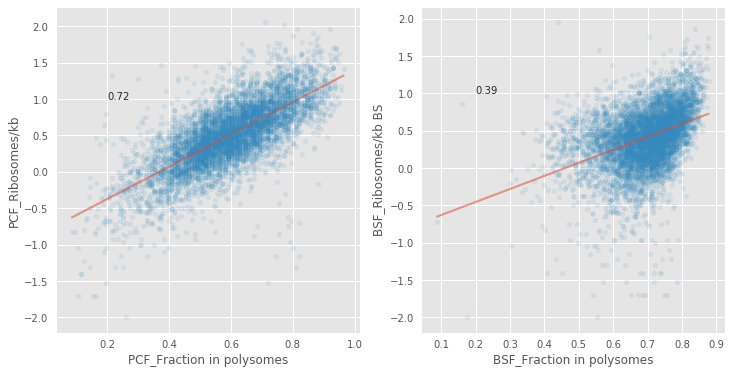

In [140]:
import scipy as sp
def plot_line(x,y,ax):
    linreg = sp.stats.linregress(x, y)
    ax.plot(x, linreg.slope*x + linreg.intercept,alpha=0.5)
    ax.text(0.2, 1, round(linreg.rvalue,2))

fig,axes=plt.subplots(figsize=(12,6),ncols=2)
ax=axes[1]
x='BSF_Fraction in polysomes'
y='BSF_Ribosomes/kb BS'
test.plot(x=x,
          y=y,kind='scatter',ax=ax,
         alpha=0.1)
plot_line(test[x],test[y],ax)
ax=axes[0]
x='PCF_Fraction in polysomes'
y='PCF_Ribosomes/kb'
test.plot(x='PCF_Fraction in polysomes',
          y='PCF_Ribosomes/kb',kind='scatter',ax=ax,
         alpha=0.1)
plot_line(test[x],test[y],ax)

In [141]:
TDdf2 = pd.concat([
        #Traslation Competent BSF
        ((out_df['B_pol_1']/0.7) / ((out_df['B_pol_1']/0.7) + (out_df['B_sub_1']/0.3))),
        ((out_df['B_pol_2']/0.7) / ((out_df['B_pol_2']/0.7) + (out_df['B_sub_2']/0.3))),
        ((out_df['B_pol_3']/0.7) / ((out_df['B_pol_3']/0.7) + (out_df['B_sub_3']/0.3))),
        #Traslation Competent PCF
        ((out_df['P_pol_1']/0.7) / ((out_df['P_pol_1']/0.7) + (out_df['P_sub_1']/0.3))),
        ((out_df['P_pol_2']/0.7) / ((out_df['P_pol_2']/0.7) + (out_df['P_sub_2']/0.3))),
        ((out_df['P_pol_3']/0.7) / ((out_df['P_pol_3']/0.7) + (out_df['P_sub_3']/0.3)))],
        #BSF vs PCF
         axis=1)


TDdf2.columns = ['B1','B2','B3','P1','P2','P3']
TDdf2['median_b']=TDdf2[['B1','B2','B3']].median(axis=1)
TDdf2['median_p']=TDdf2[['P1','P2','P3']].median(axis=1)
TDdf2.head()

,B1,B2,B3,P1,P2,P3,median_b,median_p
Tb927.8.230,0.082392,0.105955,0.110115,NaN,NaN,1.000000,0.105955,1.000000
Tb927.8.480,0.369781,0.388638,0.429699,0.048496,0.062739,0.064343,0.388638,0.062739
Tb927.8.490,0.144708,0.140121,0.108523,0.188866,0.161782,0.148422,0.140121,0.161782
Tb927.8.500,0.030717,0.029479,0.018783,0.052190,0.027870,0.021816,0.029479,0.027870
Tb927.8.510,0.057689,0.096650,0.039978,0.130326,0.131776,0.103837,0.057689,0.130326


In [142]:
test=test.join(TDdf2[['median_b','median_p']]).replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()
test.head()

,BSF_Fraction in polysomes,PCF_Fraction in polysomes,BSF_Ribosomes/kb BS,PCF_Ribosomes/kb,median_b,median_p
Tb927.1.1000,0.615,0.585,0.164353,0.553883,0.355258,0.342714
Tb927.1.1010,0.703,0.475,0.451786,0.296665,0.298378,0.233873
Tb927.1.1020,0.724,0.450,0.468347,0.107210,0.382397,0.287492
Tb927.1.1030,0.596,0.445,0.000000,0.093422,0.164066,0.222183
Tb927.1.1050,0.755,0.665,0.167317,0.666518,0.542043,0.333868


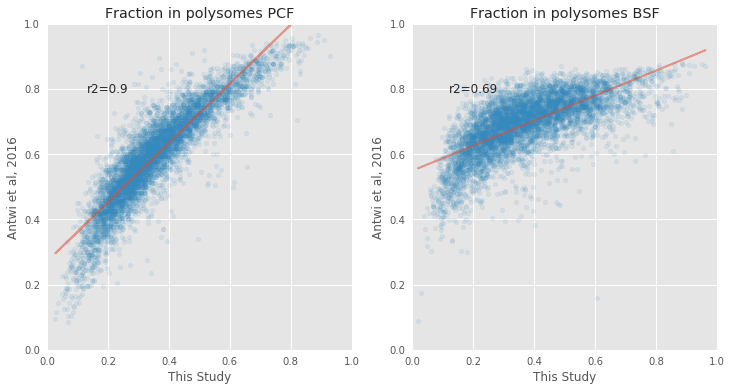

In [143]:
test=test.dropna()

fig,axes=plt.subplots(figsize=(12,6), ncols=2)

x='median_b'
y='BSF_Fraction in polysomes'
test.plot(x=x,
          y=y,kind='scatter',ax=axes[1],
          alpha=0.1)
UT.plot_line(test[x],test[y],axes[1])


axes[1].set_title('Fraction in polysomes BSF')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].set_ylabel('Antwi et al, 2016')
axes[1].set_xlabel('This Study')


x='median_p'
y='PCF_Fraction in polysomes'
test.plot(x=x,
          y=y,kind='scatter',ax=axes[0],
         alpha=0.1)
UT.plot_line(test[x],test[y],axes[0])


axes[0].set_title('Fraction in polysomes PCF')
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].set_ylabel('Antwi et al, 2016')
axes[0].set_xlabel('This Study')

plt.savefig('Figures/Figure_5.png')
plt.show()